# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    validation = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_val, y_val = validation['features'], validation['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_val = X_val.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_val))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Image examples in training set

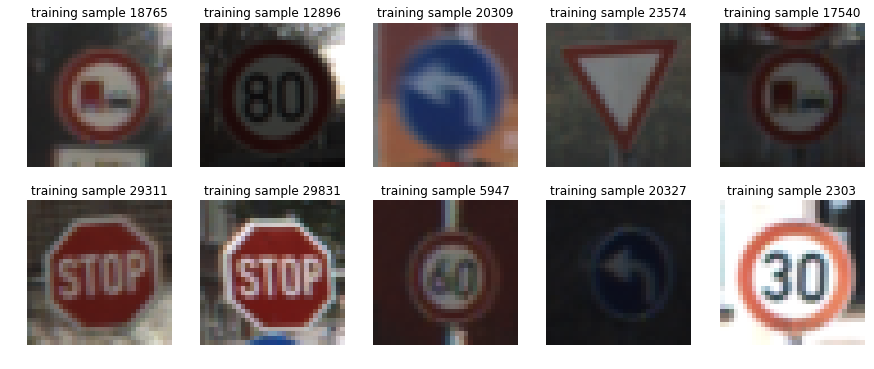

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Show some traffic sign images in training set
img_index = np.random.randint(n_train, size=10)
f, axarr = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axarr[i, j].imshow(X_train[img_index[i*5+j]])
        axarr[i, j].set_title('training sample ' + str(img_index[i*5+j]))
        axarr[i, j].axis('off')

### Image examples in validation set

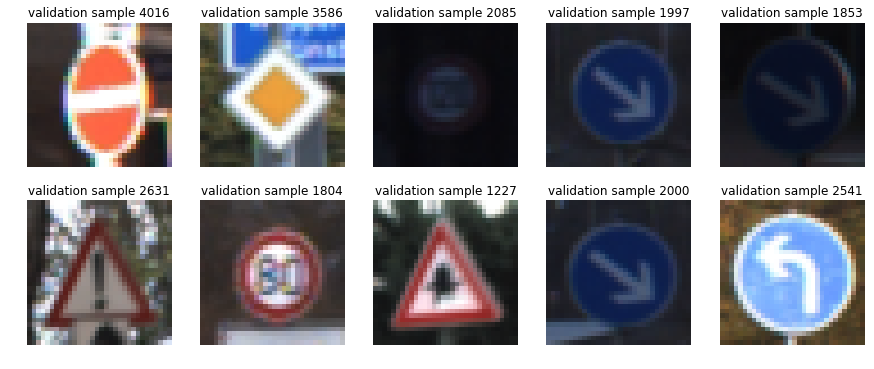

In [4]:
# Show some traffic sign images in validation set
img_index = np.random.randint(n_val, size=10)
f, axarr = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axarr[i, j].imshow(X_val[img_index[i*5+j]])
        axarr[i, j].set_title('validation sample ' + str(img_index[i*5+j]))
        axarr[i, j].axis('off')

### Image examples in test set

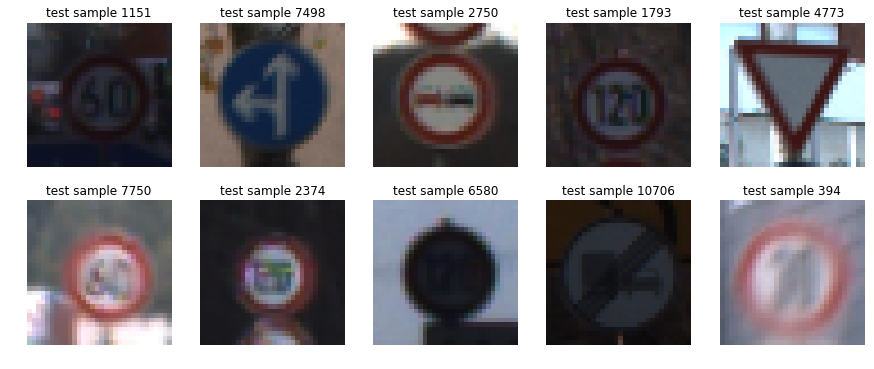

In [5]:
# Show some traffic sign images in test set
img_index = np.random.randint(n_test, size=10)
f, axarr = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axarr[i, j].imshow(X_test[img_index[i*5+j]])
        axarr[i, j].set_title('test sample ' + str(img_index[i*5+j]))
        axarr[i, j].axis('off')

### Label class distribution in Training, Validation, and Test sets

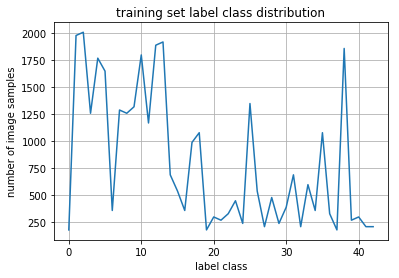

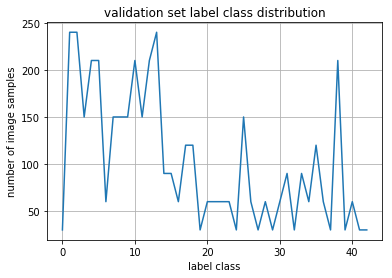

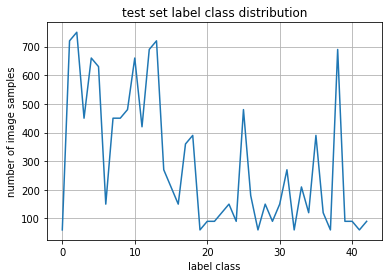

In [6]:
# Show label class distribution of traffic sign image in training set
x = np.unique(y_train)
y = np.bincount(y_train)

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='label class', ylabel='number of image samples',
       title='training set label class distribution')
ax.grid()


# Show label class distribution of traffic sign image in validation set
x = np.unique(y_val)
y = np.bincount(y_val)

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='label class', ylabel='number of image samples',
       title='validation set label class distribution')
ax.grid()

# Show label class distribution of traffic sign image in test set
x = np.unique(y_test)
y = np.bincount(y_test)

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='label class', ylabel='number of image samples',
       title='test set label class distribution')
ax.grid()

plt.show()


## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

import tensorflow as tf

print('tensorflow version = {}'.format(tf.__version__))

# Normalize image samples
def normalize_image(image_set, image_mean=128, num_channel=3):
    return (image_set - np.repeat(image_mean, num_channel)) / image_mean

X_train = normalize_image(X_train)

tensorflow version = 1.3.0


### LeNet Model Architecture

* Input [32x32x3]
* 6 Filters, 5x5, Stride 1, ReLU [28x28x6]
* Max Pool 2x2, Stride 2 [14x14x6]
* 16 Filters, 5x5, Stride 1, ReLU [10x10x16]
* Max Pool 2x2, Stride 2 [5x5x16]
* Flatten [400]
* Fully Connected size 120, ReLU [120]
* Fully Connected size [n_classes = 43]


In [8]:
def LeNet(x):
    """
    Compute LeNet class score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of input images, shape [batch_size, 32, 32, 3]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, n_classes], 
    containing the class score for each input image.
    """
    global n_classes
    
    with tf.variable_scope("LeNet"):
        # Use xavier initializer as initializer for all weight variables
        init = tf.contrib.layers.xavier_initializer(uniform=True)

        # Neural Network architecture        
        a = tf.layers.conv2d(inputs=x, filters=6, kernel_size=5, padding='VALID', 
                             activation=tf.nn.relu, kernel_initializer=init)
        a = tf.layers.max_pooling2d(a, pool_size=2, strides=2, padding='SAME')
        a = tf.layers.conv2d(inputs=a, filters=16, kernel_size=5, padding='VALID', 
                             activation=tf.nn.relu, kernel_initializer=init)
        a = tf.layers.max_pooling2d(a, pool_size=2, strides=2, padding='SAME')
        a = tf.contrib.layers.flatten(a)
        a = tf.layers.dense(a, 120, activation=tf.nn.relu, kernel_initializer=init)
        logits = tf.layers.dense(a, n_classes, kernel_initializer=init)
    
        return logits

### Model evaluation and training

In [9]:
from sklearn.utils import shuffle

def evaluate(X_data, y_data, accuracy, batch_size=64):
    '''
    Evaluate predict accuracy on a data set, normally validation set
    
    Input:
    - X_data: data set for placeholder x
    - y_data: label set for placeholder y
    - accuracy: operator of prediction accuracy
    - batch_size: mini-batch size for evaluation
    
    Return:
    - accuracy: total prediction accuracy on this data set
    '''
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        batch_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (batch_accuracy * len(batch_x))
    return total_accuracy / num_examples


def train(sess, loss, accuracy, train_step, X_train, y_train, X_val, y_val,
          batch_size=64, num_epoch=10, print_every=100, verbose=False):
    '''
    Run mini-batch training, show training loss, training accuracy, and validation accuracy

    Input:
    - sess: session to run model training
    - loss: operator of model loss
    - accuracy: operator of prediction accuracy
    - train_step: operator of training step to minimize loss
    - X_train: training set data for placeholder x
    - y_train: training set label for place holder y
    - X_val: validation set data for placeholder x
    - y_val: validation set data for placeholder y
    - batch_size: mini-batch size of training data
    - num_epoch: number of training epochs
    - print_every: number of iterations to print training loss and accuracy
    - verbose: print detailed info when it set to True

    Returns:
    - train_accuracy: prediction accuracy on last epoch of training
    - validation_accuracy: prediction accuracy on validation set
    '''    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    variables = [loss, accuracy, train_step]    
        
    if verbose:
        print("")
        print("Training...")
    
    for i in range(num_epoch):
        epoch_correction = 0.0
        X_train, y_train = shuffle(X_train, y_train)
        
        # Train model with mini batch of training data
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_loss, batch_accuracy, _ = sess.run(variables, feed_dict={x: batch_x, y: batch_y})
        
            # Aggreate batch correct predictions to epoch level
            epoch_correction += batch_accuracy * batch_size
        
            # Print loss and batch training accuracy after every "print_every" iterations
            iter_counter = offset // batch_size
            if verbose and iter_counter % print_every == 0:
                print("iteration:{}, batch loss={:.3f}, batch accuracy={:.3f}".
                      format(iter_counter, batch_loss, batch_accuracy))
        
        # Print epoch training accuracy and epoch validation accuracy
        train_accuracy = epoch_correction / num_examples
        validation_accuracy = evaluate(X_val, y_val, accuracy, batch_size)
        if verbose:
            print("EPOCH:{}, train_accuracy={:.3f}, validation accuracy={:.3f}".
                  format(i+1, train_accuracy, validation_accuracy))

    return train_accuracy, validation_accuracy

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Search for best hyperparameter combination for each model type

In [12]:
model = 'LeNet'

# Hyperparameters candidate values
learning_rates = 10 ** np.random.uniform(-4, -1, 50)
batch_sizes = [16, 32, 64, 128]
num_epoch = 2

# Dictionary to store accuracy result of hyperparameter combinations
hyperparameter_dict = {}

# Search for best hyperparameter combination
print('model={}'.format(model))

iteration_counter = 0
for lr in learning_rates:
    for bs in batch_sizes:
        # Reset tf graph for each iteration 
        tf.reset_default_graph()

        # Define model place holders for images and labels
        x = tf.placeholder(tf.float32, (None, 32, 32, 3))
        y = tf.placeholder(tf.int32, (None))

        # Define loss, accuray, and train_step
        if model == 'ResNet':
            raise not_implemented
        elif model == 'Inception_v3':
            raise not_implemented
        elif model == 'Inception_v4':
            raise not_implemented
        else:
            logits = LeNet(x)
        
        one_hot_y = tf.one_hot(y, n_classes)        
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
        loss = tf.reduce_mean(cross_entropy)
        
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)
        train_step = optimizer.minimize(loss)

        # Run training and check training accuracy and validation accuracy
        with tf.Session() as sess:
            iteration_counter += 1
            print("")
            print('Hyperparameter combination {}'.format(iteration_counter))
            train_accuracy, val_accuracy = train(sess, loss, accuracy, train_step, X_train, y_train, X_val, y_val,
                                                 batch_size=bs, num_epoch=num_epoch, print_every=100, verbose=True)
            print('learning rate={:.2e}, batch size={}, train accuracy={:.3f}, validation accuracy={:.3f}'
                  .format(lr, bs, train_accuracy, val_accuracy))
            hyperparameter_dict[(lr, bs)] = (train_accuracy, val_accuracy)
            
# Sort and print result list 
print("")
print("")
print('Result list (sorted by validation accuracy)')
hyperparameter_dict = sorted(hyperparameter_dict.items(), key=lambda x:x[1][1])
for h in hyperparameter_dict:
    print('learning rate={:.2e}, batch size={}, train accuracy={:.3f}, validation accuracy={:.3f}'
          .format(h[0][0], h[0][1], h[1][0], h[1][1]))
            

model=LeNet

Hyperparameter combination 1

Training...
iteration:0, batch loss=3.724, batch accuracy=0.125
iteration:100, batch loss=3.811, batch accuracy=0.062
iteration:200, batch loss=3.456, batch accuracy=0.188
iteration:300, batch loss=3.224, batch accuracy=0.188
iteration:400, batch loss=3.318, batch accuracy=0.062
iteration:500, batch loss=3.568, batch accuracy=0.000
iteration:600, batch loss=3.591, batch accuracy=0.000
iteration:700, batch loss=3.478, batch accuracy=0.000
iteration:800, batch loss=3.452, batch accuracy=0.000
iteration:900, batch loss=3.633, batch accuracy=0.062
iteration:1000, batch loss=3.514, batch accuracy=0.062
iteration:1100, batch loss=3.471, batch accuracy=0.125
iteration:1200, batch loss=3.646, batch accuracy=0.062
iteration:1300, batch loss=3.726, batch accuracy=0.062
iteration:1400, batch loss=3.452, batch accuracy=0.125
iteration:1500, batch loss=3.199, batch accuracy=0.125
iteration:1600, batch loss=3.208, batch accuracy=0.062
iteration:1700, batch 

iteration:0, batch loss=3.776, batch accuracy=0.031
iteration:100, batch loss=2.269, batch accuracy=0.312
iteration:200, batch loss=0.989, batch accuracy=0.781
iteration:300, batch loss=0.680, batch accuracy=0.812
iteration:400, batch loss=0.488, batch accuracy=0.812
iteration:500, batch loss=0.111, batch accuracy=0.969
iteration:600, batch loss=0.206, batch accuracy=0.938
iteration:700, batch loss=0.197, batch accuracy=0.969
iteration:800, batch loss=0.127, batch accuracy=0.938
iteration:900, batch loss=0.120, batch accuracy=0.938
iteration:1000, batch loss=0.200, batch accuracy=0.906
EPOCH:1, train_accuracy=0.828, validation accuracy=0.871
iteration:0, batch loss=0.507, batch accuracy=0.938
iteration:100, batch loss=0.244, batch accuracy=0.906
iteration:200, batch loss=0.058, batch accuracy=0.969
iteration:300, batch loss=0.447, batch accuracy=0.969
iteration:400, batch loss=0.094, batch accuracy=0.969
iteration:500, batch loss=0.099, batch accuracy=0.938
iteration:600, batch loss=0.

EPOCH:2, train_accuracy=0.057, validation accuracy=0.054
learning rate=3.48e-02, batch size=128, train accuracy=0.057, validation accuracy=0.054

Hyperparameter combination 13

Training...
iteration:0, batch loss=3.744, batch accuracy=0.000
iteration:100, batch loss=2.995, batch accuracy=0.188
iteration:200, batch loss=1.321, batch accuracy=0.625
iteration:300, batch loss=1.537, batch accuracy=0.562
iteration:400, batch loss=1.006, batch accuracy=0.688
iteration:500, batch loss=1.300, batch accuracy=0.562
iteration:600, batch loss=1.121, batch accuracy=0.750
iteration:700, batch loss=0.388, batch accuracy=0.938
iteration:800, batch loss=1.224, batch accuracy=0.688
iteration:900, batch loss=0.225, batch accuracy=0.938
iteration:1000, batch loss=0.171, batch accuracy=1.000
iteration:1100, batch loss=0.321, batch accuracy=0.938
iteration:1200, batch loss=0.195, batch accuracy=0.938
iteration:1300, batch loss=0.279, batch accuracy=0.875
iteration:1400, batch loss=0.308, batch accuracy=0.93


Hyperparameter combination 18

Training...
iteration:0, batch loss=3.814, batch accuracy=0.000
iteration:100, batch loss=3.397, batch accuracy=0.094
iteration:200, batch loss=3.450, batch accuracy=0.000
iteration:300, batch loss=3.606, batch accuracy=0.094
iteration:400, batch loss=3.414, batch accuracy=0.125
iteration:500, batch loss=3.473, batch accuracy=0.062
iteration:600, batch loss=3.492, batch accuracy=0.031
iteration:700, batch loss=3.741, batch accuracy=0.062
iteration:800, batch loss=3.365, batch accuracy=0.031
iteration:900, batch loss=3.484, batch accuracy=0.125
iteration:1000, batch loss=3.445, batch accuracy=0.062
EPOCH:1, train_accuracy=0.055, validation accuracy=0.054
iteration:0, batch loss=3.442, batch accuracy=0.125
iteration:100, batch loss=3.348, batch accuracy=0.062
iteration:200, batch loss=3.212, batch accuracy=0.062
iteration:300, batch loss=3.351, batch accuracy=0.031
iteration:400, batch loss=3.492, batch accuracy=0.031
iteration:500, batch loss=3.482, batch

iteration:200, batch loss=0.319, batch accuracy=0.898
EPOCH:2, train_accuracy=0.872, validation accuracy=0.657
learning rate=9.29e-04, batch size=128, train accuracy=0.872, validation accuracy=0.657

Hyperparameter combination 25

Training...
iteration:0, batch loss=3.731, batch accuracy=0.062
iteration:100, batch loss=3.813, batch accuracy=0.000
iteration:200, batch loss=3.508, batch accuracy=0.062
iteration:300, batch loss=3.267, batch accuracy=0.000
iteration:400, batch loss=3.615, batch accuracy=0.062
iteration:500, batch loss=3.381, batch accuracy=0.000
iteration:600, batch loss=3.444, batch accuracy=0.062
iteration:700, batch loss=3.601, batch accuracy=0.000
iteration:800, batch loss=3.522, batch accuracy=0.062
iteration:900, batch loss=3.223, batch accuracy=0.000
iteration:1000, batch loss=3.370, batch accuracy=0.062
iteration:1100, batch loss=3.391, batch accuracy=0.062
iteration:1200, batch loss=3.460, batch accuracy=0.062
iteration:1300, batch loss=3.452, batch accuracy=0.062

EPOCH:2, train_accuracy=0.954, validation accuracy=0.837
learning rate=2.45e-03, batch size=16, train accuracy=0.954, validation accuracy=0.837

Hyperparameter combination 30

Training...
iteration:0, batch loss=3.810, batch accuracy=0.000
iteration:100, batch loss=2.129, batch accuracy=0.469
iteration:200, batch loss=0.798, batch accuracy=0.750
iteration:300, batch loss=0.404, batch accuracy=0.906
iteration:400, batch loss=0.440, batch accuracy=0.938
iteration:500, batch loss=0.252, batch accuracy=0.938
iteration:600, batch loss=0.181, batch accuracy=0.969
iteration:700, batch loss=0.288, batch accuracy=0.938
iteration:800, batch loss=0.187, batch accuracy=0.969
iteration:900, batch loss=0.260, batch accuracy=0.938
iteration:1000, batch loss=0.033, batch accuracy=1.000
EPOCH:1, train_accuracy=0.834, validation accuracy=0.885
iteration:0, batch loss=0.108, batch accuracy=0.969
iteration:100, batch loss=0.324, batch accuracy=0.906
iteration:200, batch loss=0.051, batch accuracy=1.000
it

EPOCH:1, train_accuracy=0.629, validation accuracy=0.454
iteration:0, batch loss=0.454, batch accuracy=0.852
iteration:100, batch loss=0.349, batch accuracy=0.906
iteration:200, batch loss=0.421, batch accuracy=0.914
EPOCH:2, train_accuracy=0.873, validation accuracy=0.518
learning rate=1.70e-02, batch size=128, train accuracy=0.873, validation accuracy=0.518

Hyperparameter combination 37

Training...
iteration:0, batch loss=3.802, batch accuracy=0.062
iteration:100, batch loss=2.676, batch accuracy=0.188
iteration:200, batch loss=2.143, batch accuracy=0.250
iteration:300, batch loss=1.092, batch accuracy=0.750
iteration:400, batch loss=1.395, batch accuracy=0.500
iteration:500, batch loss=0.882, batch accuracy=0.750
iteration:600, batch loss=0.594, batch accuracy=0.875
iteration:700, batch loss=0.483, batch accuracy=0.750
iteration:800, batch loss=0.798, batch accuracy=0.812
iteration:900, batch loss=0.268, batch accuracy=0.938
iteration:1000, batch loss=0.313, batch accuracy=0.938
i

iteration:1900, batch loss=0.432, batch accuracy=0.938
iteration:2000, batch loss=0.253, batch accuracy=0.875
iteration:2100, batch loss=0.648, batch accuracy=0.750
EPOCH:2, train_accuracy=0.869, validation accuracy=0.524
learning rate=2.93e-04, batch size=16, train accuracy=0.869, validation accuracy=0.524

Hyperparameter combination 42

Training...
iteration:0, batch loss=3.785, batch accuracy=0.000
iteration:100, batch loss=3.256, batch accuracy=0.125
iteration:200, batch loss=2.605, batch accuracy=0.250
iteration:300, batch loss=1.722, batch accuracy=0.500
iteration:400, batch loss=1.664, batch accuracy=0.469
iteration:500, batch loss=1.354, batch accuracy=0.625
iteration:600, batch loss=1.184, batch accuracy=0.594
iteration:700, batch loss=1.346, batch accuracy=0.562
iteration:800, batch loss=1.009, batch accuracy=0.688
iteration:900, batch loss=0.680, batch accuracy=0.875
iteration:1000, batch loss=0.950, batch accuracy=0.781
EPOCH:1, train_accuracy=0.547, validation accuracy=0.4

iteration:0, batch loss=3.725, batch accuracy=0.023
iteration:100, batch loss=0.873, batch accuracy=0.773
iteration:200, batch loss=0.404, batch accuracy=0.883
EPOCH:1, train_accuracy=0.729, validation accuracy=0.841
iteration:0, batch loss=0.233, batch accuracy=0.930
iteration:100, batch loss=0.087, batch accuracy=0.984
iteration:200, batch loss=0.215, batch accuracy=0.930
EPOCH:2, train_accuracy=0.954, validation accuracy=0.749
learning rate=6.78e-03, batch size=128, train accuracy=0.954, validation accuracy=0.749

Hyperparameter combination 49

Training...
iteration:0, batch loss=3.735, batch accuracy=0.000
iteration:100, batch loss=2.623, batch accuracy=0.188
iteration:200, batch loss=1.089, batch accuracy=0.625
iteration:300, batch loss=0.901, batch accuracy=0.750
iteration:400, batch loss=1.050, batch accuracy=0.562
iteration:500, batch loss=0.232, batch accuracy=1.000
iteration:600, batch loss=0.453, batch accuracy=0.812
iteration:700, batch loss=0.204, batch accuracy=0.875
iter

iteration:1600, batch loss=0.800, batch accuracy=0.812
iteration:1700, batch loss=0.057, batch accuracy=1.000
iteration:1800, batch loss=0.335, batch accuracy=0.875
iteration:1900, batch loss=0.127, batch accuracy=0.938
iteration:2000, batch loss=0.000, batch accuracy=1.000
iteration:2100, batch loss=0.002, batch accuracy=1.000
EPOCH:2, train_accuracy=0.950, validation accuracy=0.551
learning rate=3.57e-03, batch size=16, train accuracy=0.950, validation accuracy=0.551

Hyperparameter combination 54

Training...
iteration:0, batch loss=3.778, batch accuracy=0.031
iteration:100, batch loss=1.518, batch accuracy=0.594
iteration:200, batch loss=0.446, batch accuracy=0.906
iteration:300, batch loss=0.482, batch accuracy=0.875
iteration:400, batch loss=0.773, batch accuracy=0.812
iteration:500, batch loss=0.201, batch accuracy=0.938
iteration:600, batch loss=0.296, batch accuracy=0.875
iteration:700, batch loss=0.182, batch accuracy=0.906
iteration:800, batch loss=0.128, batch accuracy=0.96


Hyperparameter combination 60

Training...
iteration:0, batch loss=3.798, batch accuracy=0.023
iteration:100, batch loss=3.201, batch accuracy=0.227
iteration:200, batch loss=2.600, batch accuracy=0.273
EPOCH:1, train_accuracy=0.255, validation accuracy=0.370
iteration:0, batch loss=2.062, batch accuracy=0.422
iteration:100, batch loss=1.644, batch accuracy=0.516
iteration:200, batch loss=1.130, batch accuracy=0.727
EPOCH:2, train_accuracy=0.579, validation accuracy=0.445
learning rate=2.49e-04, batch size=128, train accuracy=0.579, validation accuracy=0.445

Hyperparameter combination 61

Training...
iteration:0, batch loss=3.747, batch accuracy=0.125
iteration:100, batch loss=3.112, batch accuracy=0.062
iteration:200, batch loss=1.797, batch accuracy=0.500
iteration:300, batch loss=1.756, batch accuracy=0.438
iteration:400, batch loss=1.604, batch accuracy=0.500
iteration:500, batch loss=1.846, batch accuracy=0.500
iteration:600, batch loss=1.347, batch accuracy=0.625
iteration:700,

iteration:1500, batch loss=0.265, batch accuracy=0.938
iteration:1600, batch loss=0.235, batch accuracy=1.000
iteration:1700, batch loss=0.533, batch accuracy=0.875
iteration:1800, batch loss=0.148, batch accuracy=1.000
iteration:1900, batch loss=0.171, batch accuracy=0.938
iteration:2000, batch loss=0.045, batch accuracy=1.000
iteration:2100, batch loss=0.296, batch accuracy=0.875
EPOCH:2, train_accuracy=0.928, validation accuracy=0.722
learning rate=3.06e-04, batch size=16, train accuracy=0.928, validation accuracy=0.722

Hyperparameter combination 66

Training...
iteration:0, batch loss=3.827, batch accuracy=0.000
iteration:100, batch loss=3.030, batch accuracy=0.281
iteration:200, batch loss=2.644, batch accuracy=0.406
iteration:300, batch loss=2.010, batch accuracy=0.469
iteration:400, batch loss=1.667, batch accuracy=0.500
iteration:500, batch loss=1.670, batch accuracy=0.594
iteration:600, batch loss=1.356, batch accuracy=0.656
iteration:700, batch loss=1.292, batch accuracy=0.5

EPOCH:2, train_accuracy=0.573, validation accuracy=0.319
learning rate=1.13e-04, batch size=64, train accuracy=0.573, validation accuracy=0.319

Hyperparameter combination 72

Training...
iteration:0, batch loss=3.755, batch accuracy=0.031
iteration:100, batch loss=3.483, batch accuracy=0.078
iteration:200, batch loss=3.118, batch accuracy=0.234
EPOCH:1, train_accuracy=0.173, validation accuracy=0.066
iteration:0, batch loss=2.768, batch accuracy=0.289
iteration:100, batch loss=2.420, batch accuracy=0.414
iteration:200, batch loss=2.160, batch accuracy=0.375
EPOCH:2, train_accuracy=0.408, validation accuracy=0.233
learning rate=1.13e-04, batch size=128, train accuracy=0.408, validation accuracy=0.233

Hyperparameter combination 73

Training...
iteration:0, batch loss=3.925, batch accuracy=0.000
iteration:100, batch loss=3.682, batch accuracy=0.125
iteration:200, batch loss=3.665, batch accuracy=0.000
iteration:300, batch loss=3.532, batch accuracy=0.000
iteration:400, batch loss=3.389,

iteration:1300, batch loss=3.627, batch accuracy=0.000
iteration:1400, batch loss=3.438, batch accuracy=0.062
iteration:1500, batch loss=3.485, batch accuracy=0.062
iteration:1600, batch loss=3.277, batch accuracy=0.062
iteration:1700, batch loss=3.531, batch accuracy=0.188
iteration:1800, batch loss=3.163, batch accuracy=0.125
iteration:1900, batch loss=3.800, batch accuracy=0.000
iteration:2000, batch loss=3.418, batch accuracy=0.000
iteration:2100, batch loss=3.258, batch accuracy=0.125
EPOCH:2, train_accuracy=0.057, validation accuracy=0.054
learning rate=1.75e-02, batch size=16, train accuracy=0.057, validation accuracy=0.054

Hyperparameter combination 78

Training...
iteration:0, batch loss=3.766, batch accuracy=0.000
iteration:100, batch loss=3.296, batch accuracy=0.094
iteration:200, batch loss=2.158, batch accuracy=0.469
iteration:300, batch loss=2.155, batch accuracy=0.469
iteration:400, batch loss=1.074, batch accuracy=0.594
iteration:500, batch loss=1.309, batch accuracy=0

iteration:400, batch loss=0.336, batch accuracy=0.922
iteration:500, batch loss=0.181, batch accuracy=0.938
EPOCH:2, train_accuracy=0.947, validation accuracy=0.656
learning rate=6.49e-03, batch size=64, train accuracy=0.947, validation accuracy=0.656

Hyperparameter combination 84

Training...
iteration:0, batch loss=3.801, batch accuracy=0.031
iteration:100, batch loss=0.663, batch accuracy=0.789
iteration:200, batch loss=0.329, batch accuracy=0.914
EPOCH:1, train_accuracy=0.783, validation accuracy=0.865
iteration:0, batch loss=0.180, batch accuracy=0.953
iteration:100, batch loss=0.195, batch accuracy=0.969
iteration:200, batch loss=0.203, batch accuracy=0.938
EPOCH:2, train_accuracy=0.952, validation accuracy=0.855
learning rate=6.49e-03, batch size=128, train accuracy=0.952, validation accuracy=0.855

Hyperparameter combination 85

Training...
iteration:0, batch loss=3.857, batch accuracy=0.000
iteration:100, batch loss=3.540, batch accuracy=0.000
iteration:200, batch loss=3.615,

iteration:1100, batch loss=0.032, batch accuracy=1.000
iteration:1200, batch loss=0.098, batch accuracy=0.938
iteration:1300, batch loss=0.189, batch accuracy=0.938
iteration:1400, batch loss=0.103, batch accuracy=0.938
iteration:1500, batch loss=0.008, batch accuracy=1.000
iteration:1600, batch loss=0.165, batch accuracy=0.875
iteration:1700, batch loss=1.079, batch accuracy=0.875
iteration:1800, batch loss=0.105, batch accuracy=1.000
iteration:1900, batch loss=0.767, batch accuracy=0.812
iteration:2000, batch loss=0.071, batch accuracy=1.000
iteration:2100, batch loss=0.024, batch accuracy=1.000
EPOCH:2, train_accuracy=0.920, validation accuracy=0.607
learning rate=4.71e-03, batch size=16, train accuracy=0.920, validation accuracy=0.607

Hyperparameter combination 90

Training...
iteration:0, batch loss=3.803, batch accuracy=0.031
iteration:100, batch loss=1.478, batch accuracy=0.562
iteration:200, batch loss=0.763, batch accuracy=0.781
iteration:300, batch loss=0.516, batch accuracy

iteration:200, batch loss=0.639, batch accuracy=0.812
iteration:300, batch loss=0.648, batch accuracy=0.828
iteration:400, batch loss=0.363, batch accuracy=0.922
iteration:500, batch loss=0.656, batch accuracy=0.828
EPOCH:2, train_accuracy=0.783, validation accuracy=0.484
learning rate=3.28e-04, batch size=64, train accuracy=0.783, validation accuracy=0.484

Hyperparameter combination 96

Training...
iteration:0, batch loss=3.794, batch accuracy=0.039
iteration:100, batch loss=2.845, batch accuracy=0.328
iteration:200, batch loss=1.911, batch accuracy=0.469
EPOCH:1, train_accuracy=0.329, validation accuracy=0.220
iteration:0, batch loss=1.621, batch accuracy=0.539
iteration:100, batch loss=1.178, batch accuracy=0.648
iteration:200, batch loss=0.952, batch accuracy=0.719
EPOCH:2, train_accuracy=0.651, validation accuracy=0.345
learning rate=3.28e-04, batch size=128, train accuracy=0.651, validation accuracy=0.345

Hyperparameter combination 97

Training...
iteration:0, batch loss=3.881,

iteration:900, batch loss=0.389, batch accuracy=0.812
iteration:1000, batch loss=0.247, batch accuracy=0.938
iteration:1100, batch loss=0.292, batch accuracy=0.938
iteration:1200, batch loss=0.285, batch accuracy=0.938
iteration:1300, batch loss=0.683, batch accuracy=0.875
iteration:1400, batch loss=0.398, batch accuracy=0.875
iteration:1500, batch loss=0.109, batch accuracy=1.000
iteration:1600, batch loss=0.128, batch accuracy=0.938
iteration:1700, batch loss=0.476, batch accuracy=0.938
iteration:1800, batch loss=0.138, batch accuracy=1.000
iteration:1900, batch loss=0.097, batch accuracy=1.000
iteration:2000, batch loss=0.160, batch accuracy=1.000
iteration:2100, batch loss=0.013, batch accuracy=1.000
EPOCH:2, train_accuracy=0.921, validation accuracy=0.764
learning rate=3.21e-04, batch size=16, train accuracy=0.921, validation accuracy=0.764

Hyperparameter combination 102

Training...
iteration:0, batch loss=3.851, batch accuracy=0.031
iteration:100, batch loss=3.084, batch accura

iteration:0, batch loss=0.043, batch accuracy=0.984
iteration:100, batch loss=0.091, batch accuracy=0.953
iteration:200, batch loss=0.192, batch accuracy=0.984
iteration:300, batch loss=0.148, batch accuracy=0.953
iteration:400, batch loss=0.125, batch accuracy=0.969
iteration:500, batch loss=0.292, batch accuracy=0.906
EPOCH:2, train_accuracy=0.958, validation accuracy=0.875
learning rate=6.09e-03, batch size=64, train accuracy=0.958, validation accuracy=0.875

Hyperparameter combination 108

Training...
iteration:0, batch loss=3.800, batch accuracy=0.008
iteration:100, batch loss=0.604, batch accuracy=0.797
iteration:200, batch loss=0.217, batch accuracy=0.930
EPOCH:1, train_accuracy=0.790, validation accuracy=0.724
iteration:0, batch loss=0.172, batch accuracy=0.945
iteration:100, batch loss=0.189, batch accuracy=0.945
iteration:200, batch loss=0.099, batch accuracy=0.953
EPOCH:2, train_accuracy=0.960, validation accuracy=0.817
learning rate=6.09e-03, batch size=128, train accuracy=

iteration:700, batch loss=0.015, batch accuracy=1.000
iteration:800, batch loss=0.030, batch accuracy=1.000
iteration:900, batch loss=0.030, batch accuracy=1.000
iteration:1000, batch loss=0.471, batch accuracy=0.875
iteration:1100, batch loss=0.005, batch accuracy=1.000
iteration:1200, batch loss=0.163, batch accuracy=1.000
iteration:1300, batch loss=0.407, batch accuracy=0.938
iteration:1400, batch loss=0.028, batch accuracy=1.000
iteration:1500, batch loss=0.347, batch accuracy=0.938
iteration:1600, batch loss=0.060, batch accuracy=0.938
iteration:1700, batch loss=0.016, batch accuracy=1.000
iteration:1800, batch loss=0.144, batch accuracy=0.938
iteration:1900, batch loss=0.880, batch accuracy=0.875
iteration:2000, batch loss=0.353, batch accuracy=0.875
iteration:2100, batch loss=0.365, batch accuracy=0.938
EPOCH:2, train_accuracy=0.950, validation accuracy=0.598
learning rate=3.15e-03, batch size=16, train accuracy=0.950, validation accuracy=0.598

Hyperparameter combination 114

T

iteration:500, batch loss=1.860, batch accuracy=0.469
EPOCH:1, train_accuracy=0.334, validation accuracy=0.302
iteration:0, batch loss=1.717, batch accuracy=0.531
iteration:100, batch loss=1.433, batch accuracy=0.656
iteration:200, batch loss=1.222, batch accuracy=0.609
iteration:300, batch loss=1.111, batch accuracy=0.703
iteration:400, batch loss=1.305, batch accuracy=0.609
iteration:500, batch loss=1.166, batch accuracy=0.703
EPOCH:2, train_accuracy=0.644, validation accuracy=0.373
learning rate=1.86e-04, batch size=64, train accuracy=0.644, validation accuracy=0.373

Hyperparameter combination 120

Training...
iteration:0, batch loss=3.794, batch accuracy=0.055
iteration:100, batch loss=3.198, batch accuracy=0.234
iteration:200, batch loss=2.210, batch accuracy=0.461
EPOCH:1, train_accuracy=0.284, validation accuracy=0.224
iteration:0, batch loss=2.027, batch accuracy=0.492
iteration:100, batch loss=1.669, batch accuracy=0.516
iteration:200, batch loss=1.247, batch accuracy=0.680
E

iteration:500, batch loss=0.255, batch accuracy=0.875
iteration:600, batch loss=0.412, batch accuracy=0.938
iteration:700, batch loss=0.049, batch accuracy=1.000
iteration:800, batch loss=0.044, batch accuracy=1.000
iteration:900, batch loss=0.073, batch accuracy=1.000
iteration:1000, batch loss=0.505, batch accuracy=0.875
iteration:1100, batch loss=0.169, batch accuracy=0.938
iteration:1200, batch loss=0.074, batch accuracy=0.938
iteration:1300, batch loss=0.110, batch accuracy=0.938
iteration:1400, batch loss=0.231, batch accuracy=0.938
iteration:1500, batch loss=0.017, batch accuracy=1.000
iteration:1600, batch loss=0.008, batch accuracy=1.000
iteration:1700, batch loss=0.033, batch accuracy=1.000
iteration:1800, batch loss=0.174, batch accuracy=0.938
iteration:1900, batch loss=0.246, batch accuracy=0.938
iteration:2000, batch loss=0.025, batch accuracy=1.000
iteration:2100, batch loss=0.005, batch accuracy=1.000
EPOCH:2, train_accuracy=0.956, validation accuracy=0.723
learning rate

iteration:300, batch loss=0.407, batch accuracy=0.875
iteration:400, batch loss=0.470, batch accuracy=0.844
iteration:500, batch loss=0.405, batch accuracy=0.875
EPOCH:1, train_accuracy=0.738, validation accuracy=0.768
iteration:0, batch loss=0.217, batch accuracy=0.938
iteration:100, batch loss=0.205, batch accuracy=0.938
iteration:200, batch loss=0.485, batch accuracy=0.828
iteration:300, batch loss=0.261, batch accuracy=0.922
iteration:400, batch loss=0.192, batch accuracy=0.938
iteration:500, batch loss=0.266, batch accuracy=0.906
EPOCH:2, train_accuracy=0.924, validation accuracy=0.735
learning rate=8.19e-03, batch size=64, train accuracy=0.924, validation accuracy=0.735

Hyperparameter combination 132

Training...
iteration:0, batch loss=3.803, batch accuracy=0.000
iteration:100, batch loss=0.466, batch accuracy=0.852
iteration:200, batch loss=0.342, batch accuracy=0.922
EPOCH:1, train_accuracy=0.746, validation accuracy=0.750
iteration:0, batch loss=0.182, batch accuracy=0.922
i

iteration:300, batch loss=0.719, batch accuracy=0.688
iteration:400, batch loss=0.513, batch accuracy=0.875
iteration:500, batch loss=0.087, batch accuracy=1.000
iteration:600, batch loss=0.662, batch accuracy=0.750
iteration:700, batch loss=0.110, batch accuracy=1.000
iteration:800, batch loss=0.325, batch accuracy=0.812
iteration:900, batch loss=0.311, batch accuracy=0.938
iteration:1000, batch loss=0.238, batch accuracy=0.875
iteration:1100, batch loss=0.179, batch accuracy=0.938
iteration:1200, batch loss=0.243, batch accuracy=0.938
iteration:1300, batch loss=0.689, batch accuracy=0.812
iteration:1400, batch loss=0.178, batch accuracy=0.938
iteration:1500, batch loss=0.455, batch accuracy=0.812
iteration:1600, batch loss=0.651, batch accuracy=0.875
iteration:1700, batch loss=0.529, batch accuracy=0.875
iteration:1800, batch loss=0.502, batch accuracy=0.875
iteration:1900, batch loss=1.265, batch accuracy=0.875
iteration:2000, batch loss=0.553, batch accuracy=0.750
iteration:2100, b

iteration:100, batch loss=3.394, batch accuracy=0.078
iteration:200, batch loss=3.542, batch accuracy=0.047
iteration:300, batch loss=3.447, batch accuracy=0.031
iteration:400, batch loss=3.467, batch accuracy=0.047
iteration:500, batch loss=3.649, batch accuracy=0.047
EPOCH:1, train_accuracy=0.056, validation accuracy=0.054
iteration:0, batch loss=3.518, batch accuracy=0.062
iteration:100, batch loss=3.663, batch accuracy=0.031
iteration:200, batch loss=3.748, batch accuracy=0.000
iteration:300, batch loss=3.415, batch accuracy=0.031
iteration:400, batch loss=3.479, batch accuracy=0.031
iteration:500, batch loss=3.572, batch accuracy=0.047
EPOCH:2, train_accuracy=0.057, validation accuracy=0.048
learning rate=3.38e-02, batch size=64, train accuracy=0.057, validation accuracy=0.048

Hyperparameter combination 144

Training...
iteration:0, batch loss=3.829, batch accuracy=0.055
iteration:100, batch loss=3.569, batch accuracy=0.023
iteration:200, batch loss=3.455, batch accuracy=0.062
EP

iteration:100, batch loss=1.504, batch accuracy=0.688
iteration:200, batch loss=0.190, batch accuracy=0.938
iteration:300, batch loss=1.111, batch accuracy=0.688
iteration:400, batch loss=0.013, batch accuracy=1.000
iteration:500, batch loss=0.215, batch accuracy=0.875
iteration:600, batch loss=0.761, batch accuracy=0.750
iteration:700, batch loss=0.244, batch accuracy=0.938
iteration:800, batch loss=0.179, batch accuracy=0.938
iteration:900, batch loss=0.407, batch accuracy=0.938
iteration:1000, batch loss=0.097, batch accuracy=1.000
iteration:1100, batch loss=0.063, batch accuracy=1.000
iteration:1200, batch loss=0.005, batch accuracy=1.000
iteration:1300, batch loss=0.475, batch accuracy=0.875
iteration:1400, batch loss=0.169, batch accuracy=0.938
iteration:1500, batch loss=0.126, batch accuracy=1.000
iteration:1600, batch loss=0.108, batch accuracy=1.000
iteration:1700, batch loss=0.890, batch accuracy=0.938
iteration:1800, batch loss=0.163, batch accuracy=0.938
iteration:1900, bat


Hyperparameter combination 155

Training...
iteration:0, batch loss=3.744, batch accuracy=0.031
iteration:100, batch loss=1.189, batch accuracy=0.656
iteration:200, batch loss=0.523, batch accuracy=0.828
iteration:300, batch loss=0.379, batch accuracy=0.859
iteration:400, batch loss=0.272, batch accuracy=0.906
iteration:500, batch loss=0.219, batch accuracy=0.938
EPOCH:1, train_accuracy=0.769, validation accuracy=0.735
iteration:0, batch loss=0.211, batch accuracy=0.953
iteration:100, batch loss=0.211, batch accuracy=0.906
iteration:200, batch loss=0.171, batch accuracy=0.938
iteration:300, batch loss=0.153, batch accuracy=0.953
iteration:400, batch loss=0.126, batch accuracy=0.953
iteration:500, batch loss=0.046, batch accuracy=0.984
EPOCH:2, train_accuracy=0.951, validation accuracy=0.736
learning rate=5.71e-03, batch size=64, train accuracy=0.951, validation accuracy=0.736

Hyperparameter combination 156

Training...
iteration:0, batch loss=3.823, batch accuracy=0.008
iteration:100

EPOCH:1, train_accuracy=0.054, validation accuracy=0.054
iteration:0, batch loss=3.598, batch accuracy=0.000
iteration:100, batch loss=3.526, batch accuracy=0.000
iteration:200, batch loss=3.423, batch accuracy=0.062
iteration:300, batch loss=3.380, batch accuracy=0.062
iteration:400, batch loss=3.374, batch accuracy=0.125
iteration:500, batch loss=3.687, batch accuracy=0.062
iteration:600, batch loss=3.487, batch accuracy=0.125
iteration:700, batch loss=3.558, batch accuracy=0.062
iteration:800, batch loss=3.667, batch accuracy=0.062
iteration:900, batch loss=3.837, batch accuracy=0.062
iteration:1000, batch loss=3.413, batch accuracy=0.000
iteration:1100, batch loss=3.386, batch accuracy=0.000
iteration:1200, batch loss=3.869, batch accuracy=0.062
iteration:1300, batch loss=3.629, batch accuracy=0.000
iteration:1400, batch loss=3.197, batch accuracy=0.125
iteration:1500, batch loss=3.357, batch accuracy=0.188
iteration:1600, batch loss=3.267, batch accuracy=0.125
iteration:1700, batc

EPOCH:2, train_accuracy=0.965, validation accuracy=0.870
learning rate=2.22e-03, batch size=32, train accuracy=0.965, validation accuracy=0.870

Hyperparameter combination 167

Training...
iteration:0, batch loss=3.810, batch accuracy=0.016
iteration:100, batch loss=1.366, batch accuracy=0.641
iteration:200, batch loss=0.413, batch accuracy=0.859
iteration:300, batch loss=0.531, batch accuracy=0.859
iteration:400, batch loss=0.309, batch accuracy=0.938
iteration:500, batch loss=0.296, batch accuracy=0.906
EPOCH:1, train_accuracy=0.769, validation accuracy=0.722
iteration:0, batch loss=0.131, batch accuracy=0.984
iteration:100, batch loss=0.083, batch accuracy=0.984
iteration:200, batch loss=0.098, batch accuracy=1.000
iteration:300, batch loss=0.244, batch accuracy=0.984
iteration:400, batch loss=0.173, batch accuracy=0.984
iteration:500, batch loss=0.071, batch accuracy=0.984
EPOCH:2, train_accuracy=0.963, validation accuracy=0.741
learning rate=2.22e-03, batch size=64, train accuracy

iteration:1900, batch loss=0.969, batch accuracy=0.875
iteration:2000, batch loss=0.752, batch accuracy=0.812
iteration:2100, batch loss=1.013, batch accuracy=0.562
EPOCH:1, train_accuracy=0.534, validation accuracy=0.475
iteration:0, batch loss=0.990, batch accuracy=0.812
iteration:100, batch loss=0.848, batch accuracy=0.750
iteration:200, batch loss=0.866, batch accuracy=0.938
iteration:300, batch loss=0.858, batch accuracy=0.750
iteration:400, batch loss=0.549, batch accuracy=0.875
iteration:500, batch loss=1.284, batch accuracy=0.625
iteration:600, batch loss=0.590, batch accuracy=0.875
iteration:700, batch loss=0.497, batch accuracy=0.875
iteration:800, batch loss=0.634, batch accuracy=0.812
iteration:900, batch loss=0.546, batch accuracy=0.938
iteration:1000, batch loss=0.371, batch accuracy=0.875
iteration:1100, batch loss=0.529, batch accuracy=0.812
iteration:1200, batch loss=0.446, batch accuracy=0.875
iteration:1300, batch loss=0.432, batch accuracy=1.000
iteration:1400, batc

iteration:800, batch loss=0.310, batch accuracy=0.938
iteration:900, batch loss=0.191, batch accuracy=0.938
iteration:1000, batch loss=0.098, batch accuracy=1.000
EPOCH:2, train_accuracy=0.899, validation accuracy=0.556
learning rate=4.40e-04, batch size=32, train accuracy=0.899, validation accuracy=0.556

Hyperparameter combination 179

Training...
iteration:0, batch loss=3.816, batch accuracy=0.000
iteration:100, batch loss=2.855, batch accuracy=0.219
iteration:200, batch loss=1.890, batch accuracy=0.516
iteration:300, batch loss=1.357, batch accuracy=0.578
iteration:400, batch loss=1.186, batch accuracy=0.734
iteration:500, batch loss=0.968, batch accuracy=0.781
EPOCH:1, train_accuracy=0.527, validation accuracy=0.506
iteration:0, batch loss=0.797, batch accuracy=0.750
iteration:100, batch loss=0.515, batch accuracy=0.875
iteration:200, batch loss=0.837, batch accuracy=0.766
iteration:300, batch loss=0.521, batch accuracy=0.859
iteration:400, batch loss=0.442, batch accuracy=0.875
i

iteration:1600, batch loss=0.538, batch accuracy=0.875
iteration:1700, batch loss=0.159, batch accuracy=0.938
iteration:1800, batch loss=0.425, batch accuracy=0.875
iteration:1900, batch loss=0.099, batch accuracy=1.000
iteration:2000, batch loss=0.374, batch accuracy=0.875
iteration:2100, batch loss=0.867, batch accuracy=0.875
EPOCH:1, train_accuracy=0.852, validation accuracy=0.731
iteration:0, batch loss=0.209, batch accuracy=0.875
iteration:100, batch loss=0.097, batch accuracy=1.000
iteration:200, batch loss=0.189, batch accuracy=0.875
iteration:300, batch loss=0.491, batch accuracy=0.875
iteration:400, batch loss=0.900, batch accuracy=0.938
iteration:500, batch loss=0.126, batch accuracy=0.938
iteration:600, batch loss=0.277, batch accuracy=0.938
iteration:700, batch loss=1.356, batch accuracy=0.812
iteration:800, batch loss=0.132, batch accuracy=0.938
iteration:900, batch loss=0.151, batch accuracy=0.938
iteration:1000, batch loss=0.493, batch accuracy=0.938
iteration:1100, batc

iteration:500, batch loss=0.170, batch accuracy=0.969
iteration:600, batch loss=0.684, batch accuracy=0.906
iteration:700, batch loss=0.119, batch accuracy=0.969
iteration:800, batch loss=0.267, batch accuracy=0.906
iteration:900, batch loss=0.222, batch accuracy=0.906
iteration:1000, batch loss=0.383, batch accuracy=0.938
EPOCH:2, train_accuracy=0.928, validation accuracy=0.624
learning rate=5.72e-04, batch size=32, train accuracy=0.928, validation accuracy=0.624

Hyperparameter combination 191

Training...
iteration:0, batch loss=3.804, batch accuracy=0.000
iteration:100, batch loss=2.855, batch accuracy=0.266
iteration:200, batch loss=1.811, batch accuracy=0.516
iteration:300, batch loss=1.020, batch accuracy=0.703
iteration:400, batch loss=0.713, batch accuracy=0.797
iteration:500, batch loss=0.558, batch accuracy=0.812
EPOCH:1, train_accuracy=0.583, validation accuracy=0.605
iteration:0, batch loss=0.665, batch accuracy=0.875
iteration:100, batch loss=0.400, batch accuracy=0.859
i

iteration:1300, batch loss=0.888, batch accuracy=0.625
iteration:1400, batch loss=0.430, batch accuracy=0.688
iteration:1500, batch loss=0.406, batch accuracy=0.938
iteration:1600, batch loss=1.263, batch accuracy=0.562
iteration:1700, batch loss=1.225, batch accuracy=0.688
iteration:1800, batch loss=0.907, batch accuracy=0.750
iteration:1900, batch loss=0.592, batch accuracy=0.812
iteration:2000, batch loss=0.975, batch accuracy=0.625
iteration:2100, batch loss=0.712, batch accuracy=0.688
EPOCH:1, train_accuracy=0.634, validation accuracy=0.569
iteration:0, batch loss=0.895, batch accuracy=0.750
iteration:100, batch loss=0.702, batch accuracy=0.812
iteration:200, batch loss=0.156, batch accuracy=0.938
iteration:300, batch loss=0.980, batch accuracy=0.688
iteration:400, batch loss=0.360, batch accuracy=0.938
iteration:500, batch loss=0.675, batch accuracy=0.750
iteration:600, batch loss=0.381, batch accuracy=0.875
iteration:700, batch loss=0.408, batch accuracy=0.875
iteration:800, bat

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")